In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from embedding_utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data & Model Parameters

In [6]:
smiles = fetch_smiles_gdb13('./data/gdb13').values.tolist()

for i, smile in enumerate(smiles):
    smiles[i] = smile.replace('Cl', 'L')

### Model

In [19]:
params = make_params(smiles=smiles, GRU_HIDDEN_DIM=512, LATENT_DIM=256)

In [21]:
Decoder(params)

Decoder(
  (fc_network): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (decode_next): DecodeNext(
    (gru): GRU(21, 512, batch_first=True)
    (fc_network): Sequential(
      (0): Linear(in_features=512, out_features=21, bias=True)
      (1): Linear(in_features=21, out_features=21, bias=True)
    )
  )
)

In [22]:
encoder = Encoder(params)
encoder.load_state_dict(torch.load('weights-2/encoder_weights.pth'))

decoder = Decoder(params)
decoder.load_state_dict(torch.load('weights-2/decoder_weights.pth'))

<All keys matched successfully>

N=C1N2NC=CC=C2C2=C1OC=C2		OC1CC2CC3CC2OCC3(O)C1
O1CCCCCCCCCCCCCCCCCCCCC1		OCCCCCCCCCCCCCCCCCC1
Euclidean Distance of Means: 11.116595268249512
Euclidean Distance of Samples: 12.715621948242188


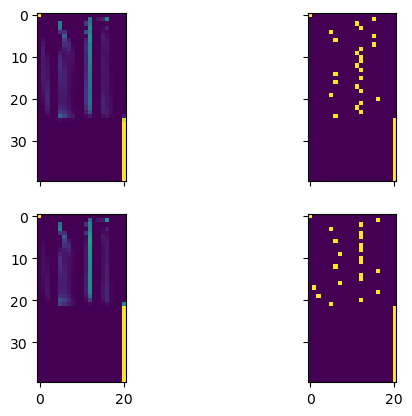

In [24]:
s1, s2 = random.sample(smiles, 2)
print(f'{s1}\t\t{s2}')

s1 = to_one_hot(s1, params)
s2 = to_one_hot(s2, params)

mu1, logvar1, z1 = encoder(s1)
mu2, logvar2, z2 = encoder(s2)

s1_pred = decoder(z1)
s2_pred = decoder(z2)

print(f'{from_one_hot(s1_pred, params)[0]}\t\t{from_one_hot(s2_pred, params)[0]}')

print(f"Euclidean Distance of Means: {float(torch.pow(torch.sum(torch.pow(mu1 - mu2, 2)), 0.5))}")
print(f"Euclidean Distance of Samples: {float(torch.pow(torch.sum(torch.pow(z1 - z2, 2)), 0.5))}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

ax1.imshow(torch.softmax(s1_pred, dim=2).squeeze(0).detach().numpy())
ax2.imshow(torch.softmax(s1, dim=2).squeeze(0).detach().numpy())

ax3.imshow(torch.softmax(s2_pred, dim=2).squeeze(0).detach().numpy())
ax4.imshow(torch.softmax(s2, dim=2).squeeze(0).detach().numpy())

## Test

In [26]:
evaluate_ae(encoder, decoder, smiles, 10, params=params)

,target,predicted
0,C1C2=C(CC11CCOCO1)N=CS2,OCCCCCCCCCCCCCCCCCCCC11
1,C1OC2C[NH2+]CC3COC1CC2O3,C1CCCC[NH2+]CCCCCCCCCCCCC
2,[NH3+]C12CC34CCC1CC(C3)C2CO4,[NH3+]C1CCCCCCCCCCCCCCCCC
3,[NH3+]C1CCOC23CCCC(CO2)C13,[NH3+]C1CCCCCCCCCCCCCCCCC
4,O=C1O[C-]2C3C[NH2+]CC(C3)NC2=C1,C1CC[NH+]]CCCCCCCCCCCCCCC
5,C1NC2C3[NH2+]CC(C13)N1N=CN=C21,C1CCCCC[NH2+]CCCCCCCCCCCC
6,C1OC23CC1C1COC2CC[NH2+]C31,O1CCCCCCCCCCCCCCC[NH2+]CC
7,C1CC23COC1C(C[NH2+]CC2)O3,O1CCCCCCCCCCC[NH2+]CCCCCC
8,OC1=CNC2=C1C1CCN2CCO1,OCCCCCCCCCCCCCCCCCCC1
9,[NH3+]C1C2COC1C1=CSN=C1CC2,[NH3+]C1CCCCCCCCCCCCCCCCC


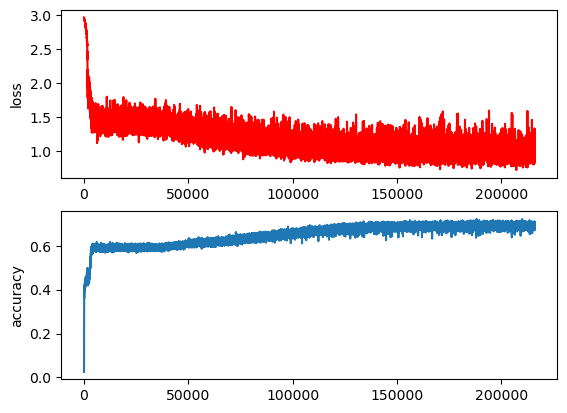

In [27]:
log = pd.read_csv('./logs/log-2.csv')

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_ylabel('loss')
ax1.plot(log['i'], log['loss'], color='red')

ax2.set_ylabel('accuracy')
ax2.plot(log['i'], log['similarity'])